In [1]:
import scipy.optimize
from itertools import cycle
import seaborn as sns
import multihist as mh
import datetime
import numba
import sys
import os
import scipy
import pandas as pd
import wimprates as wr
import numericalunits as nu
from tqdm import tqdm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import time
import dddm

import darkelf
from darkelf import targets

dddm.print_versions('dddm wimprates verne darkelf'.split())

Host DESKTOP-F4PI41P.
   module version                                                                      path                                   git
   python  3.10.4                             /home/joran/miniconda3/envs/py3.10/bin/python                                  None
     dddm   3.0.2                                            /home/joran/software/dddm/dddm branch:test_nb_and_drak_elf | 380ec29
wimprates   0.3.2 /home/joran/miniconda3/envs/py3.10/lib/python3.10/site-packages/wimprates                                  None
    verne   0.0.0                                          /home/joran/software/verne/verne               branch:master | 5121604
  darkelf   0.0.0                                      /home/joran/software/darkelf/darkelf            branch:add_setup | d877701


,module,version,path,git
0,python,3.10.4,/home/joran/miniconda3/envs/py3.10/bin/python,None
1,dddm,3.0.2,/home/joran/software/dddm/dddm,branch:test_nb_and_drak_elf | 380ec29
2,wimprates,0.3.2,/home/joran/miniconda3/envs/py3.10/lib/python3...,None
3,verne,0.0.0,/home/joran/software/verne/verne,branch:master | 5121604
4,darkelf,0.0.0,/home/joran/software/darkelf/darkelf,branch:add_setup | d877701


In [2]:
targets.files('Ge')

Available configuration files: 
	 Ge.yaml
 
Available data for epsilon: 
	 Ge_gpaw_withLFE.dat
	 Ge_Migdal_FAC.dat
	 Ge_epsphonon_data2K.dat
	 Ge_gpaw_noLFE.dat
	 Ge_epsphonon_theory6K.dat
	 Ge_mermin.dat
 
Available data for phonon (partial) density of states: 
	 Ge_DoS.dat
 
Available data for Fn(omega) functions: 
	 Ge_Fn.dat
 
Available data for form factors: 
	 Ge_atomic_Zion.dat
	 Ge_Zion.dat


In [3]:
energies = np.linspace(0, 500) # ev

In [4]:
MX = 1 #GeV/c2
SIGMA = 1e-38 #cm2
VESC=544
V0=220
RHO_0 = 0.3

In [5]:
shm = wr.StandardHaloModel(v_0=V0* nu.km/nu.s, 
                           v_esc=VESC* nu.km/nu.s,
                           rho_dm = RHO_0 * nu.GeV/nu.c0**2 / nu.cm**3 
                          )

In [6]:
dr = wr.rate_migdal(energies/1e3 * nu.keV, 
                    mw=MX * nu.GeV / nu.c0 ** 2, 
                    material='Ge',
                    sigma_nucleon=SIGMA * nu.cm ** 2,
                    halo_model=shm
                   ) * (nu.keV * (1000 * nu.kg) * nu.year)

In [7]:
Ge_gpaw = darkelf.darkelf(target='Ge', 
                          mX=MX*1e9, 
                          vesckms=VESC, 
                          v0kms=V0,
                          filename="Ge_gpaw_withLFE.dat")
Ge_gpaw.update_params(mediator='massive',)
Ge_gpaw.rhoX=0.3e9

 .... Loading files for Ge
Loaded Ge_gpaw_withLFE.dat for epsilon in electron regime
electronic ELF taken or calculated from J. Enkovaara et al.,Electronic structure calculations with GPAW: a real-space implementation of the projector augmented-wave method,Journal of Physics:Condensed Matter22(2010) 253202.
phonon ELF taken or calculated from M. Ikezawa and T. Nanba, Two-Phonon Difference Absorption Spectra in Ge Crystals, Journal of  the Physical Society of Japan 45 (1978) 148.
Loaded Ge_epsphonon_data2K.dat for epsilon in phonon regime
Zion(k) for Migdal calculation taken or calculated from: P. J. Brown, A. G. Fox, E. N. Maslen, M. A. OKeefe,and B. T. M. Willis, “Intensity of diffracted intensities,” in International Tables for Crystallography (American Cancer Society, 2006) Chap. 6.1, pp. 554–595, https://onlinelibrary.wiley.com/doi/pdf/10.1107/97809553602060000
Loaded Ge_atomic_Zion.dat for dark photon couplings
Loaded Ge_DoS.dat for density of states
Loaded Fn(omega) functions cor

In [8]:
dr_darkelf = Ge_gpaw.dRdomega_migdal(
    energies,
    sigma_n=SIGMA,
    method='ibe',     
    Nshell=6,
    approximation='impulse',
    Zionkdependence=True,
    fast=False,
)
dr_darkelf *= (
    1e3 # kg -> ton
    * 1e3 # ev ->keV
)

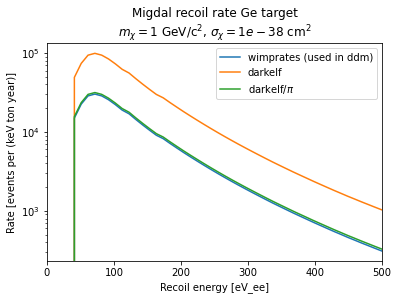

In [9]:
plt.plot(energies, dr, label='wimprates (used in ddm)')
plt.plot(energies, dr_darkelf, label='darkelf')
plt.plot(energies, dr_darkelf/np.pi, label='darkelf/$\pi$')

plt.xlabel("Recoil energy [eV_ee]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title(f"Migdal recoil rate Ge target\n$m_\chi = {MX}$ GeV/c${{}}^2$, $\sigma_\chi = {SIGMA}$ cm${{}}^2$")
plt.xlim(0, energies.max())

plt.yscale('log')
plt.legend()

In [17]:
print('Outputs')
print(f'en={list(energies)}\n\nwr={list(dr)}\n\ndark_elf={list(dr_darkelf)}')

Outputs
en=[0.0, 10.204081632653061, 20.408163265306122, 30.612244897959183, 40.816326530612244, 51.0204081632653, 61.224489795918366, 71.42857142857143, 81.63265306122449, 91.83673469387755, 102.0408163265306, 112.24489795918367, 122.44897959183673, 132.6530612244898, 142.85714285714286, 153.0612244897959, 163.26530612244898, 173.46938775510205, 183.6734693877551, 193.87755102040816, 204.0816326530612, 214.28571428571428, 224.48979591836735, 234.6938775510204, 244.89795918367346, 255.10204081632654, 265.3061224489796, 275.51020408163265, 285.7142857142857, 295.9183673469388, 306.1224489795918, 316.3265306122449, 326.53061224489795, 336.734693877551, 346.9387755102041, 357.1428571428571, 367.3469387755102, 377.55102040816325, 387.7551020408163, 397.9591836734694, 408.1632653061224, 418.3673469387755, 428.57142857142856, 438.7755102040816, 448.9795918367347, 459.18367346938777, 469.3877551020408, 479.59183673469386, 489.7959183673469, 500.0]

wr=[0.0, 0.0, 0.0, 0.0, 15007.170740112839, 